# Conditional Generative Adversarial Network for the Fashion MNIST dataset

Joaquim Minarelli Gaspar

ENSTA Paris, Institut Polytechnique de Paris

ROB313 - Deep Learning in Computer Vision

2024/2025

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Fashion MNIST dataset

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.1MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


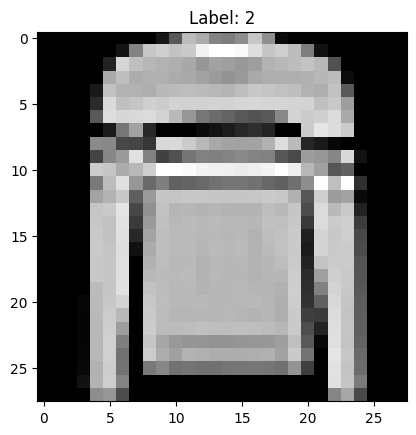

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
fashion_mnist  = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# mnist  = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# sample image from the dataset
image, label = fashion_mnist [5]

# dataset classes
classes = fashion_mnist.classes
print('Classes:', classes)

# display the image
image = image.squeeze().numpy()
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, labels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        # Defining the labels using one-hot enconding
        self.one_hot_labels = F.one_hot(labels, num_classes=10).float()

        # Defining the network
        self.fc1 = nn.Linear(latent_dim + 10, 256) # hidden layer 1 (+ 10 since we have 10 possible fashion items)
        self.fc2 = nn.Linear(256, 512) # hidden layer 2
        self.fc3 = nn.Linear(512, 784) # output layer (output dimension = 784 = 28 * 28)

    def forward(self, X, label):
      # Concatenating the embbeding with the input
      X = X.view(X.size(0), self.latent_dim)
      label_embedding = self.one_hot_labels[label]
      X = torch.cat((X, label_embedding), dim=1)

      # Applying the activation functions
      A0 = X
      A1 = F.leaky_relu(self.fc1(A0), negative_slope=0.01) # activation function for hidden layer 1
      A2 = F.leaky_relu(self.fc2(A1), negative_slope=0.01) # activation function for hidden layer 2
      A3 = F.tanh(self.fc3(A2)) # activation function for hidden layer 3

      return A3

def generator_training_loop(generator, discriminator, optimizer_G, criterion, batch_size):
  # Creating the fake labels (random from 0 to 9)
  fake_labels = torch.randint(0, 10, (batch_size,))

  # Declaring the noise and generating fake images
  noise = torch.randn(batch_size, generator.latent_dim)
  optimizer_G.zero_grad()
  fake_images = generator(noise, fake_labels)

  # Discriminating the images
  discriminator_outputs = discriminator(fake_images, fake_labels)

  # Computing the loss function
  loss = criterion(discriminator_outputs, torch.ones_like(discriminator_outputs))

  # Optimization step
  loss.backward()
  optimizer_G.step()

  return loss.item()


# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, labels):
        super(Discriminator, self).__init__()
        self.image_dim = image_dim

        # Defining the labels using one-hot enconding
        self.one_hot_labels = F.one_hot(labels, num_classes=10).float()

        # Defining the network
        self.fc1 = nn.Linear(image_dim + 10, 512) # hidden layer 1 (+ 10 since we have 10 possible fashion items)
        self.fc2 = nn.Linear(512, 256) # hidden layer 2
        self.fc3 = nn.Linear(256, 1) # output layer (output dimension = 1)

    def forward(self, X, label):
      # Concatenating the embbeding with the input
      X = X.view(X.size(0), self.image_dim)
      label_embedding = self.one_hot_labels[label]
      X = torch.cat((X, label_embedding), dim=1)

      # Applying the activation functions
      A0 = X
      A1 = F.relu(self.fc1(A0)) # activation function for hidden layer 1
      A2 = F.relu(self.fc2(A1)) # activation function for hidden layer 2
      A3 = F.sigmoid(self.fc3(A2)) # activation function for hidden layer 4

      return A3

def discriminator_training_loop(generator, discriminator, optimizer_D, criterion, real_images, real_labels, batch_size):
  optimizer_D.zero_grad()

  # Evaluating fake images
  noise = torch.randn(batch_size, generator.latent_dim)
  fake_labels = torch.randint(0, 10, (batch_size,))
  fake_images = generator(noise, fake_labels)
  fake_outputs = discriminator(fake_images, fake_labels)
  fake_loss = criterion(fake_outputs, torch.zeros_like(fake_outputs))

  # Evaluating real images
  real_outputs = discriminator(real_images, real_labels)
  real_loss = criterion(real_outputs, torch.ones_like(real_outputs))

  # Computing the total loss function
  loss = fake_loss + real_loss

  # Optimization step
  loss.backward()
  optimizer_D.step()

  return loss.item()

# Training

In [ ]:
labels = list(range(0, 10))
labels = torch.tensor(labels)
discriminator = Discriminator(784, labels) # 784 = 28 * 28 = dimension of the input image
generator = Generator(100, labels) # latent dimension = 100

# Loss function
criterion = nn.BCELoss(reduction = 'mean')

# learning rate
alpha_G = 0.0002
alpha_D = 0.0002

# Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=alpha_G)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=alpha_D)

In [ ]:
data_loader = DataLoader(fashion_mnist, batch_size=64, shuffle=True)

In [ ]:
len(data_loader)

938

In [ ]:
from tqdm import tqdm
epochs = 50
generator_steps = 1
discriminator_step = 1
discriminator_losses = []
generator_losses = []
save_every = 250
for epoch in tqdm(range(epochs)):
  for i, (real_images, real_labels) in enumerate(data_loader):
    batch_size = real_images.size(0)
    for _ in range(discriminator_step): loss_D = discriminator_training_loop(generator, discriminator, optimizer_D, criterion, real_images, real_labels, batch_size)
    for _ in range(generator_steps): loss_G = generator_training_loop(generator, discriminator, optimizer_G, criterion, batch_size)
    if i % save_every == 0:
      discriminator_losses.append(loss_D)
      generator_losses.append(loss_G)
  # print(f'Epoch: {epoch}, Loss D: {loss_D}, Loss G: {loss_G}')


100%|██████████| 50/50 [26:16<00:00, 31.52s/it]


# Results

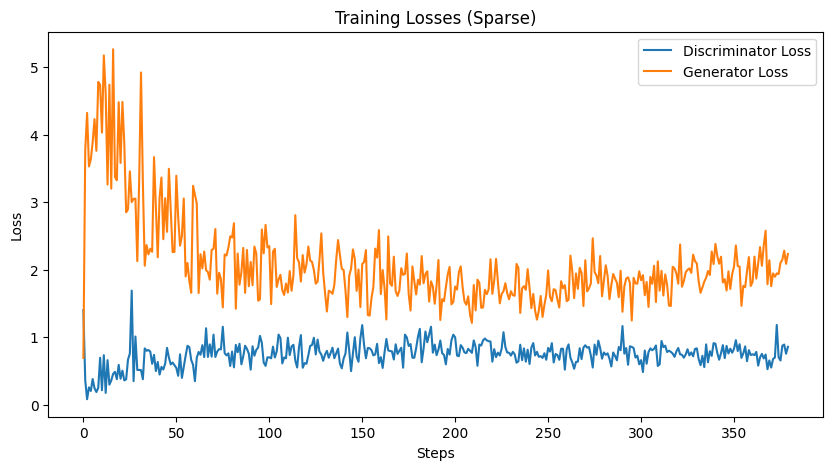

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.plot(generator_losses, label="Generator Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Losses (Sparse)")
plt.legend()
plt.show()

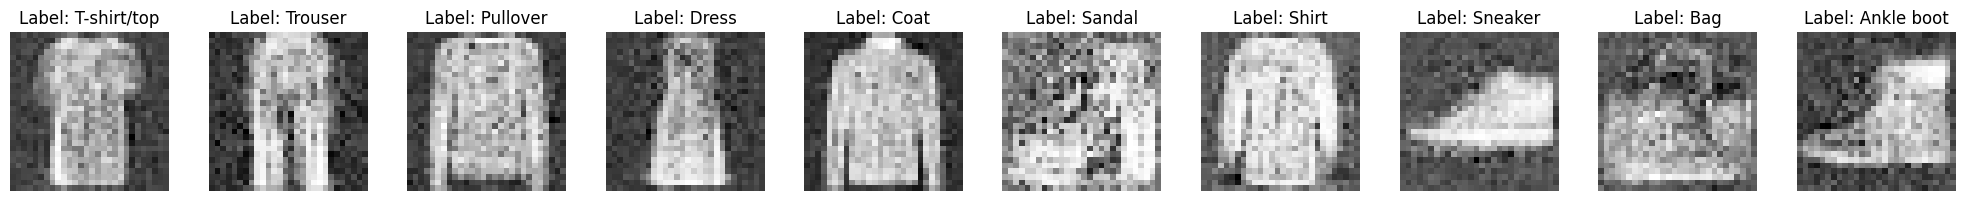

In [ ]:
num_images_per_label = 1
latent_dim = 100
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for label in range(10):
    noise = torch.randn(num_images_per_label, latent_dim)
    fake_label = torch.tensor([label] * num_images_per_label)
    generated_images = generator(noise, fake_label)
    generated_images = generated_images.view(num_images_per_label, 28, 28).detach().numpy()

    axes[label].imshow(generated_images[0], cmap='gray')
    axes[label].set_title(f"Label: {fashion_mnist.classes[label]}")
    axes[label].axis('off')

plt.tight_layout()
plt.show()